In [35]:
import os
import shutil
import random

import pandas as pd
import numpy as np

from scipy.stats import f_oneway
from scipy.stats import shapiro, bartlett
import pingouin as pg

import matplotlib.pyplot as plt
%matplotlib inline

import gc

import torch
print(torch.cuda.is_available())

from ultralytics import YOLO

np.random.seed(42)

ModuleNotFoundError: No module named 'torch'

In [2]:
df = pd.DataFrame(columns=["environment", "mAP50", "mAP50-95"])
environments = []
mAP50s = []
mAP50_95s = [] 

In [3]:
WEIGHTS_PATH = "./runs/weights_normal/350_imgs/weights/best.pt"

In [4]:
def remove_cache():
    for environment in ["dessert", "rural", "snow"]:
        path = f"./data/bias/{environment}/"
        try:
            os.remove(path+"valid/labels.cache")
        except:
            pass

In [5]:
def generate_sample():
    for environment in ["dessert", "rural", "snow"]:
        path = f"./data/bias/{environment}/"

        all_images = os.listdir(path+"all/images/")
        sample_imgs = random.sample(all_images, 30)
        sample_labels = [img[:-3]+"txt" for img in sample_imgs]

        [os.remove(path+"valid/images/"+img) for img in os.listdir(path+"valid/images/")] #remove previous sample images
        [os.remove(path+"valid/labels/"+label) for label in os.listdir(path+"valid/labels/")] #remove previous sample labels

        [shutil.copy(path+"all/images/"+img, path+"valid/images/"+img) for img in sample_imgs] #make new sample images
        [shutil.copy(path+"all/labels/"+label, path+"valid/labels/"+label) for label in sample_labels] #make new sample labels

In [6]:
for _ in range(0,100):
    remove_cache()
    generate_sample()
    
    model = YOLO(WEIGHTS_PATH)
    
    #dessert
    DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data_aug_bias_dessert.yaml"
    results_dessert = model.val(data=DATA_PATH, device="cpu")

    environments.append("dessert")
    mAP50s.append(results_dessert.results_dict['metrics/mAP50(B)'])
    mAP50_95s.append(results_dessert.results_dict['metrics/mAP50-95(B)'])
    
    #snow
    DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data_aug_bias_snow.yaml"
    results_snow = model.val(data=DATA_PATH, device="cpu")

    environments.append("snow")
    mAP50s.append(results_snow.results_dict['metrics/mAP50(B)'])
    mAP50_95s.append(results_snow.results_dict['metrics/mAP50-95(B)'])
    
    #rural
    DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data_aug_bias_rural.yaml"
    results_rural = model.val(data=DATA_PATH, device="cpu")

    environments.append("rural")
    mAP50s.append(results_rural.results_dict['metrics/mAP50(B)'])
    mAP50_95s.append(results_rural.results_dict['metrics/mAP50-95(B)'])
    
    #free up GPU memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.1.0+cu118 CPU (13th Gen Intel Core(TM) i5-13600KF)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning E:\OU\master\rm\pre_shot_sniper_detection\data\bias\dessert\valid\labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 789.54it/s]
val: New cache created: E:\OU\master\rm\pre_shot_sniper_detection\data\bias\dessert\valid\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
                   all         30         35      0.693      0.457      0.497       0.28
Speed: 1.1ms preprocess, 38.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val91
Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.1.0+cu118 CPU (13th Gen Intel Core(TM) i5-13600KF)
val: Scanning E:\OU\master\rm\pre_shot_sniper_detection\data\bias\snow\valid\labels... 30 images, 0 b

# Stat analysis

In [8]:
df["environment"] = environments
df["mAP50"] = mAP50s
df["mAP50-95"] = mAP50_95s
#df.to_csv('./excel/bias.csv')
df.head(10)

,environment,mAP50,mAP50-95
0,dessert,0.496970,0.279537
1,snow,0.578072,0.328125
2,rural,0.758120,0.480915
3,dessert,0.506833,0.259565
4,snow,0.640908,0.382660
5,rural,0.663684,0.417832
6,dessert,0.526435,0.306350
7,snow,0.513134,0.268031
8,rural,0.679751,0.431736
9,dessert,0.654795,0.339242


In [10]:
desert = df[df["environment"] == "dessert"]
snow = df[df["environment"] == "snow"]
rural = df[df["environment"] == "rural"]

### Normal distribution

In [26]:
print(f"Shapiro statistic desert: {shapiro(desert['mAP50']).statistic}")
print(f"Shapiro statistic snow: {shapiro(snow['mAP50']).statistic}")
print(f"Shapiro statistic rural: {shapiro(rural['mAP50']).statistic}")

Shapiro statistic desert: 0.9855102300643921
Shapiro statistic snow: 0.9847775101661682
Shapiro statistic rural: 0.9891202449798584


The value of this statistic tends to be high (close to 1) for samples drawn from a normal distribution. Thus we can say that we're dealing with a normal distribution

### Variance check

In [33]:
bartlett(rural["mAP50"], snow["mAP50"], desert["mAP50"])

BartlettResult(statistic=9.383037607442759, pvalue=0.009172743973523025)

We see that the statistic is quite high and that the p-value is < 0.05 and thus the hypothesis that the population variances of the three groups are equal is rejected.<br>
Because we have inequal variance we use the Welch's ANOVA

In [51]:
rural_mAP50 = list(rural["mAP50"])
snow_mAP50 = list(snow["mAP50"])
desert_mAP50 = list(desert["mAP50"])

len_rural = len(rural_mAP50)
len_snow = len(snow_mAP50)
len_desert = len(desert_mAP50)

data = pd.DataFrame({
    'value': rural_mAP50 + snow_mAP50 + desert_mAP50,
    'group': ['rural'] * len_rural + ['snow'] * len_snow + ['desert'] * len_desert
})

aov = pg.welch_anova(dv='value', between='group', data=data)

print(aov)

  Source  ddof1       ddof2          F         p-unc      np2
0  group      2  192.611907  39.266472  4.975196e-15  0.22694


In [52]:
pg.pairwise_gameshowell(dv='value', between='group', data=data)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,desert,rural,0.601485,0.658659,-0.057174,0.008580,-6.663988,188.594674,8.543626e-10,-0.943549
1,desert,snow,0.601485,0.574394,0.027090,0.009195,2.946124,179.625814,1.014473e-02,0.417139
2,rural,snow,0.658659,0.574394,0.084264,0.009957,8.463025,193.641170,1.175726e-13,1.198273


The p-value is < 0.05 thus significant. This means we can conclude that there is a difference, Further, using the post-hoc test we can see that there is a difference between all the groups

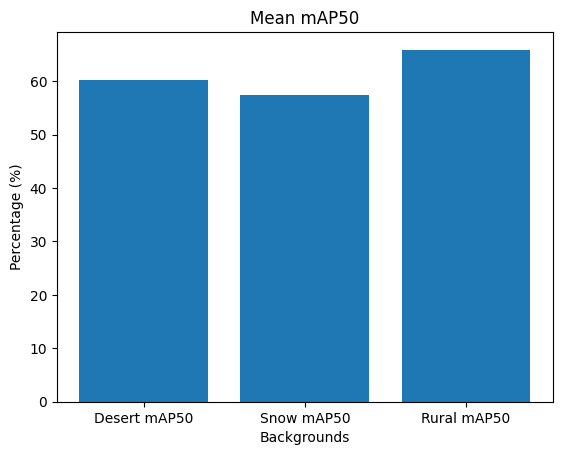

In [53]:
map50_values = (desert["mAP50"].mean(), snow["mAP50"].mean(), rural["mAP50"].mean())

percentages = [val * 100 for val in map50_values]

labels = ['Desert mAP50', 'Snow mAP50', 'Rural mAP50']

plt.bar(labels, percentages)

plt.title('Mean mAP50')
plt.xlabel('Backgrounds')
plt.ylabel('Percentage (%)')

# Show the plot
plt.savefig('./viz_img/background_bias.png')
plt.show()

It seems that the model scores best on the rural background and worst on the snow background